In [1]:
from ApertureClass import AperturePhotometry
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pickle

%matplotlib widget

In [2]:
target = AperturePhotometry()
target.aperture_photometry(69, 75, 13, 20)

In [3]:
ref01 = AperturePhotometry()
ref01.aperture_photometry(207, 32, 13, 20)

In [4]:
ref02 = AperturePhotometry()
ref02.aperture_photometry(453, 95, 13, 20)

In [5]:
differential_ref01 = target.photometry/ref01.photometry
differential_ref02 = target.photometry/ref02.photometry
differential_allref = target.photometry/(ref01.photometry + ref02.photometry)

median_bjd = np.median(target.bjd)

time_offset = 2459990
time_ingr = time_offset + 0.59
time_egr = time_offset + 0.69

out_transit_selection = (target.bjd < time_ingr) | (target.bjd > time_egr) 

from numpy.polynomial import Polynomial
poly_ref01_pfit = Polynomial.fit(target.bjd[out_transit_selection] - median_bjd, differential_ref01[out_transit_selection], deg = 2)
poly_ref02_pfit = Polynomial.fit(target.bjd[out_transit_selection] - median_bjd, differential_ref02[out_transit_selection], deg = 2)
poly_allref_pfit = Polynomial.fit(target.bjd[out_transit_selection] - median_bjd, differential_allref[out_transit_selection], deg = 2)

In [6]:
normalized_diff_ref01_photometry = differential_ref01 / poly_ref01_pfit(target.bjd - median_bjd)
normalized_diff_ref02_photometry = differential_ref02 / poly_ref02_pfit(target.bjd - median_bjd)
normalized_diff_allref_photometry = differential_allref / poly_allref_pfit(target.bjd - median_bjd)

norm_ref01_std = np.std(normalized_diff_ref01_photometry[out_transit_selection])
norm_ref02_std = np.std(normalized_diff_ref02_photometry[out_transit_selection])
norm_allref_std = np.std(normalized_diff_allref_photometry[out_transit_selection])

print(f'STD Ref#1 {norm_ref01_std:.4f}')
print(f'STD Ref#2 {norm_ref02_std:.4f}')
print(f'STD All ref {norm_allref_std:.4f}')
print()
print(f'Mean aperture Target {np.mean(target.aperture):.2f}')
print(f'Mean aperture Ref #1 {np.mean(ref01.aperture):.2f}')
print(f'Mean aperture Ref #2 {np.mean(ref02.aperture):.2f}')

STD Ref#1 0.0029
STD Ref#2 0.0028
STD All ref 0.0023

Mean aperture Target 8.73
Mean aperture Ref #1 8.82
Mean aperture Ref #2 8.74


In [7]:
differential_ref01_error = np.sqrt((target.photometry_error**2/ref01.photometry**2) + ref01.photometry_error**2 * (target.photometry/ref01.photometry**2)**2)

differential_allref_error = np.sqrt((target.photometry_error**2/(ref01.photometry + ref02.photometry)**2) + 
                                    (((ref01.photometry_error)**2)*(target.photometry/(ref01.photometry + ref02.photometry)**2)**2) +
                                    (((ref02.photometry_error)**2)*(target.photometry/(ref01.photometry + ref02.photometry)**2)**2))

#print(target.photometry_error/target.photometry *100)
#print(differential_allref_error)

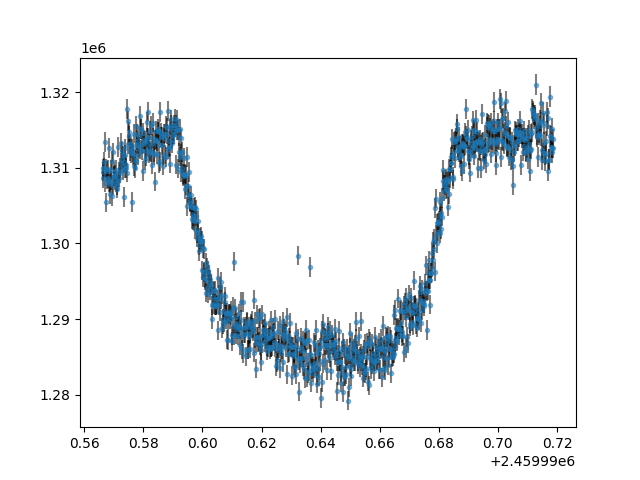

In [8]:
plt.figure()
plt.errorbar(target.bjd, target.photometry, yerr=target.photometry_error, fmt='.', ecolor='k', alpha=0.5)
plt.show()

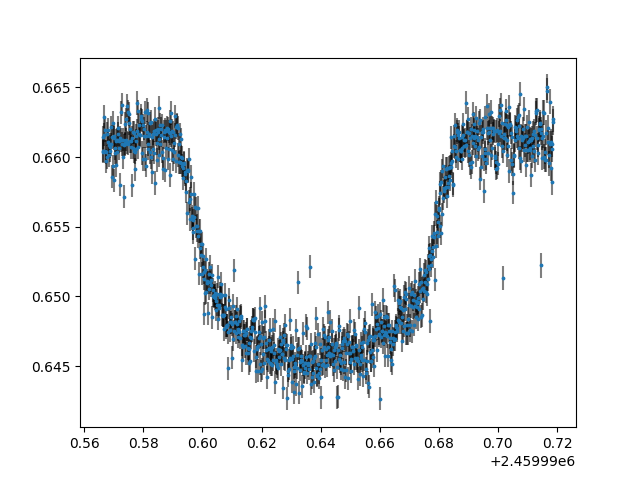

In [9]:
plt.figure()
plt.scatter(target.bjd, differential_allref, s=3)
plt.errorbar(target.bjd, differential_allref, fmt=' ', yerr=differential_allref_error, alpha=0.5, ecolor='k', zorder=-1)
plt.show()

In [10]:
bjd_bin = np.empty(41)
diff_bin = np.empty(41)

bjd = target.bjd - time_offset

for i in range(23, 944, 23):
    j = int(i/23) - 1
    k = i - 23
    bjd_bin[j] = np.median(bjd[k:i])
    diff_bin[j] = np.mean(differential_allref[k:i])


In [11]:
def make_big_circle_around_star(x_pos,y_pos,color='w',label=''):
    from matplotlib.patches import Circle
    radii=[9,15]
    n=50 #our linspace length
    theta=np.linspace(0,2*np.pi,n)
    xs=np.outer(radii,np.cos(theta))#makes x coord of inner circle, then outer circle 
    ys=np.outer(radii,np.sin(theta))#makes y coord of inner circle, then outer circle
    xs[1,:]=xs[1,::-1]
    ys[1,:]=ys[1,::-1]
    
    ax[0].fill(np.ravel(xs)+x_pos,np.ravel(ys)+y_pos,
            edgecolor=None,facecolor=color,
           alpha=0.75,
           label=label) #filling up the circle, alpha is transparency
    
def make_circle_around_star(x_pos,y_pos,radius, color='w',label='',thickness=0.75, alpha=1.): #we add radius, thickness and alpha term to our old function
    #from matplotlib.patches import Circle
    radii=[radius,radius+thickness]
    n=50 #our linspace length
    theta=np.linspace(0,2*np.pi,n)
    xs=np.outer(radii,np.cos(theta))#makes x coord of inner circle, then outer circle 
    ys=np.outer(radii,np.sin(theta))#makes y coord of inner circle, then outer circle
    xs[1,:]=xs[1,::-1]
    ys[1,:]=ys[1,::-1]
    
    ax[1].fill(np.ravel(xs)+x_pos,np.ravel(ys)+y_pos,
            edgecolor=None,facecolor=color,
           alpha=0.75,
           label=label) #filling up the circle, alpha is transparency

In [12]:
vmin = np.amin(target.science_corrected[:, 100:400, 0])
vmax = np.amax(target.science_corrected[:, 100:400, 0])

print(vmin, vmax)

940.3558877438919 33046.67737190225


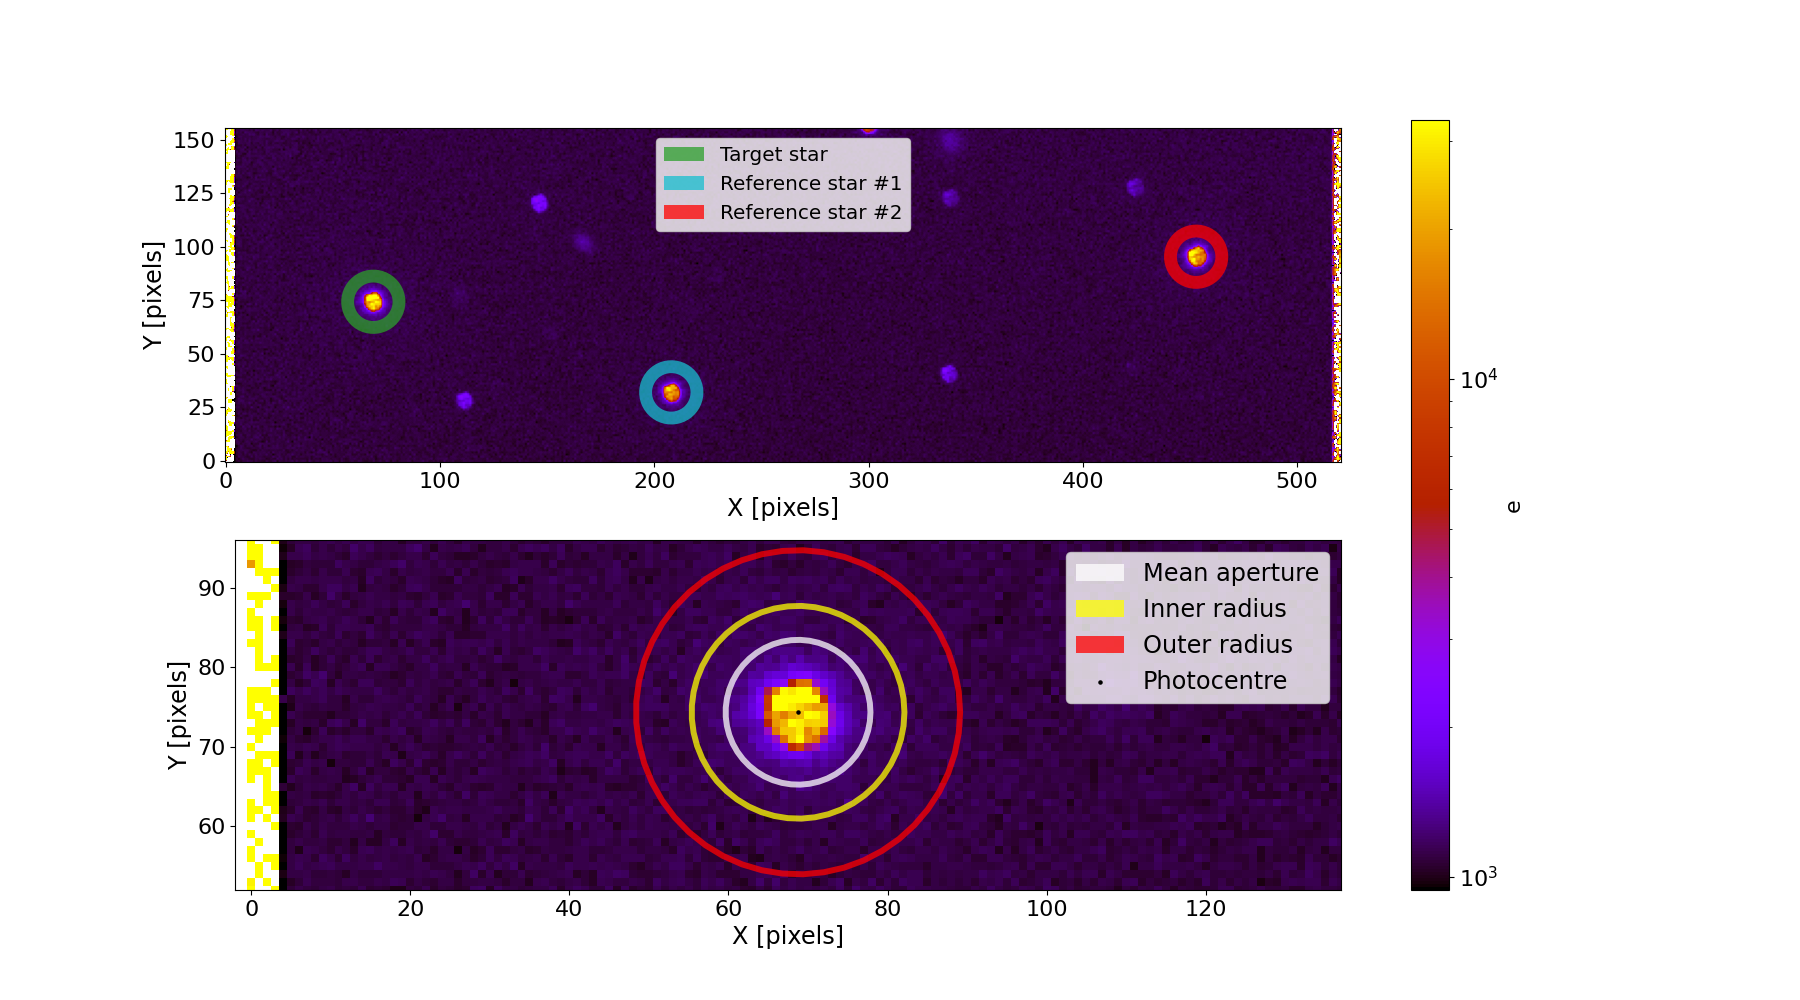

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(18, 10))
ax[0].tick_params(axis='both', labelsize=16)

ax[1].tick_params(axis='both', labelsize=16)

im = ax[0].imshow(target.science_corrected[:, :, 0], origin='lower', norm=colors.LogNorm(vmin=vmin, vmax=vmax), 
                cmap=plt.colormaps['gnuplot'])
make_big_circle_around_star(target.x_refined[0], target.y_refined[0], color='tab:green', label='Target star')
make_big_circle_around_star(ref01.x_refined[0], ref01.y_refined[0], color='tab:cyan', label='Reference star #1')
make_big_circle_around_star(ref02.x_refined[0], ref02.y_refined[0], color='r', label='Reference star #2')
ax[0].legend(loc='upper center', fontsize='x-large')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(label='e', size=16)

ax[0].set_xlabel('X [pixels]', fontsize='xx-large')
ax[0].set_ylabel('Y [pixels]', fontsize='xx-large')

xmin = int(target.x_refined[0]-71)
xmax = int(target.x_refined[0]+69)
ymin = int(target.y_refined[0]-22)
ymax = int(target.y_refined[0]+22)

ax[1].imshow(target.science_corrected[:, :, 0],
              origin='lower', norm=colors.LogNorm(vmin=vmin, vmax=vmax), 
                cmap=plt.colormaps['gnuplot'])
make_circle_around_star(target.x_refined[0], target.y_refined[0], np.mean(target.aperture), 'white', label='Mean aperture')
make_circle_around_star(target.x_refined[0], target.y_refined[0], 13, 'yellow', label='Inner radius')
make_circle_around_star(target.x_refined[0], target.y_refined[0], 20, 'r', label='Outer radius')
ax[1].scatter(target.x_refined[0], target.y_refined[0], s=5, color='k', label='Photocentre')
ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)

ax[1].set_xlabel('X [pixels]', fontsize='xx-large')
ax[1].set_ylabel('Y [pixels]', fontsize='xx-large')
ax[1].legend(loc='best', fontsize='xx-large')


cbar.ax.tick_params(labelsize=16)

#plt.savefig('./Plots/stars2_ok.png', dpi=1000)

plt.show()


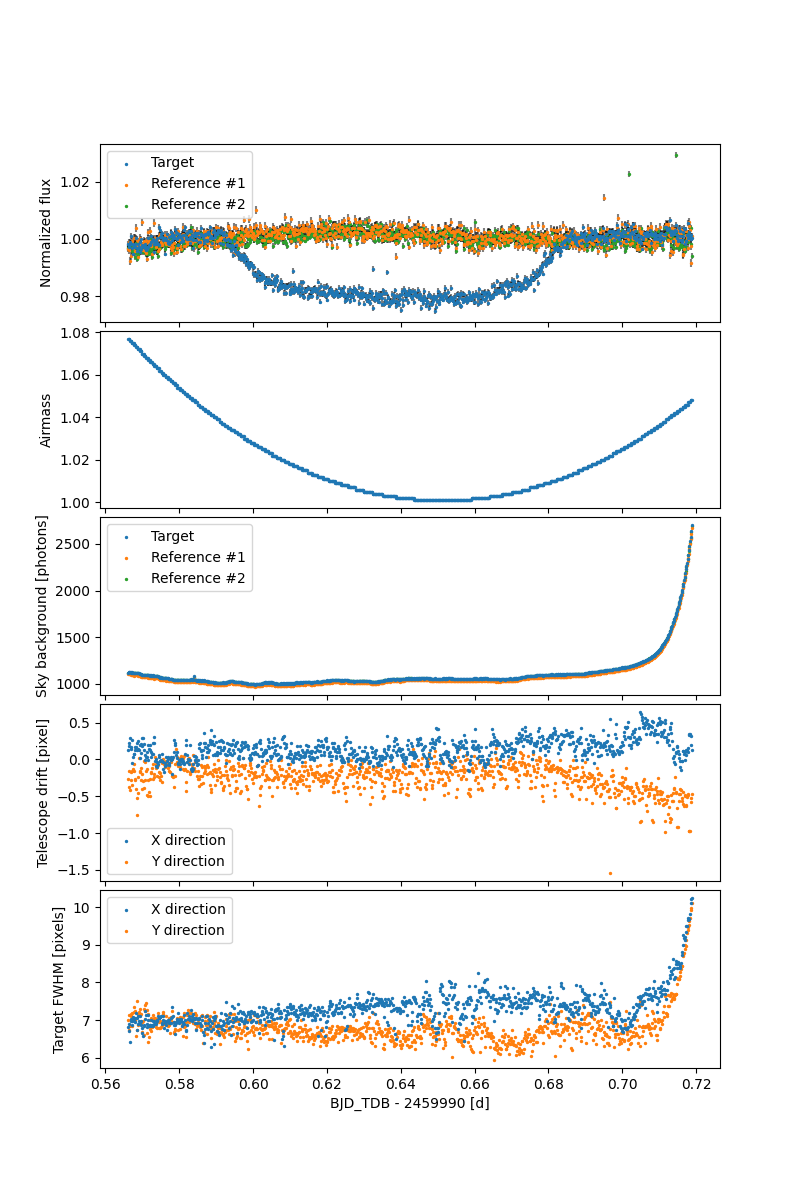

In [14]:
time_offset = 2459990.00

normalization_index = 100

fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 12))
fig.subplots_adjust(hspace=0.05)

ax[0].scatter(target.bjd - time_offset, target.photometry / target.photometry[normalization_index], 
              s=2, zorder=3, c='C0', label='Target')
ax[0].scatter(ref01.bjd - time_offset, ref01.photometry / ref01.photometry[normalization_index], 
              s=2, zorder=2, c='C1', label='Reference #1')
ax[0].scatter(ref02.bjd - time_offset, ref02.photometry / ref02.photometry[normalization_index], 
              s=2, zorder=1, c='C2', label='Reference #2')
ax[0].errorbar(target.bjd - time_offset, target.photometry / target.photometry[normalization_index], yerr=np.mean(target.photometry_error / target.photometry[normalization_index]),
                fmt=' ', ecolor='k', alpha=0.5, zorder=-1)
ax[0].errorbar(ref01.bjd - time_offset, ref01.photometry / ref01.photometry[normalization_index], yerr=np.mean(ref01.photometry_error / ref01.photometry[normalization_index]),
                fmt=' ', ecolor='k', alpha=0.5, zorder=-1)
ax[0].errorbar(ref02.bjd - time_offset, ref02.photometry / ref02.photometry[normalization_index], yerr=np.mean(ref02.photometry_error / ref02.photometry[normalization_index]),
                fmt=' ', ecolor='k', alpha=0.5, zorder=-1)

ax[0].set_ylabel('Normalized flux')
ax[0].legend()

ax[1].scatter(target.bjd - time_offset, target.airmass, s=2, c='C0', label='Airmass')
ax[1].set_ylabel('Airmass')

ax[2].scatter(target.bjd - time_offset, target.sky_background, s=2, zorder=3, c='C0', label='Target')
ax[2].scatter(ref01.bjd - time_offset, ref01.sky_background, s=2, zorder=2, c='C1', label='Reference #1')
ax[2].scatter(ref02.bjd - time_offset, ref02.sky_background, s=2, zorder=1, c='C2', label='Reference #2')
ax[2].set_ylabel('Sky background [photons]')
ax[2].legend()

ax[3].scatter(target.bjd - time_offset, target.x_refined - target.x_refined[normalization_index], s=2, zorder=3, c='C0', label='X direction')
ax[3].scatter(target.bjd - time_offset, target.y_refined - target.y_refined[normalization_index], s=2, zorder=2, c='C1', label='Y direction')
ax[3].legend()
ax[3].set_ylabel('Telescope drift [pixel]')

ax[4].scatter(target.bjd-time_offset, target.FWHM_X, s=2, zorder=3, c='C0', label='X direction')
ax[4].scatter(target.bjd-time_offset, target.FWHM_Y, s=2, zorder=2, c='C1', label='Y direction')
ax[4].set_ylabel('Target FWHM [pixels]')
ax[4].set_xlabel('BJD_TDB - 2459990 [d]')
ax[4].legend()

#plt.savefig('./Plots/night_condition.png', dpi=1000)

plt.show()

In [15]:
target_dictionary = {
    'time': target.bjd,
    'flux': target.photometry,
    'flux_err': target.photometry_error,
    'x_ref': target.x_refined,
    'y_ref': target.y_refined,
    'aperture': target.aperture,
    'background': target.sky_background,
    'background_error': target.sky_background_error,
    'inner_radius': target.inner_radius,
    'outer_radius': target.outer_radius,
    'FWHM_x': target.FWHM_X,
    'FWHM_y': target.FWHM_Y
}

ref01_dictionary = {
    'time': ref01.bjd,
    'flux': ref01.photometry,
    'flux_err': ref01.photometry_error,
    'x_ref': ref01.x_refined,
    'y_ref': ref01.y_refined,
    'aperture': ref01.aperture,
    'background': ref01.sky_background,
    'background_error': ref01.sky_background_error,
    'inner_radius': ref01.inner_radius,
    'outer_radius': ref01.outer_radius,
    'FWHM_x': ref01.FWHM_X,
    'FWHM_y': ref01.FWHM_Y
}

ref02_dictionary = {
    'time': ref02.bjd,
    'flux': ref02.photometry,
    'flux_err': ref02.photometry_error,
    'x_ref': ref02.x_refined,
    'y_ref': ref02.y_refined,
    'aperture': ref02.aperture,
    'background': ref02.sky_background,
    'background_error': ref02.sky_background_error,
    'inner_radius': ref02.inner_radius,
    'outer_radius': ref02.outer_radius,
    'FWHM_x': ref02.FWHM_X,
    'FWHM_y': ref02.FWHM_Y
}

differential_dictionary = {
    'time': target.bjd,
    'flux': differential_allref,
    'flux_error': differential_allref_error
}

pickle.dump(target_dictionary, open('../Results/TASTE/target_dictionary.p', 'wb'))
pickle.dump(ref01_dictionary, open('../Results/TASTE/ref01_dictionary.p', 'wb'))
pickle.dump(ref02_dictionary, open('../Results/TASTE/ref02_dictionary.p', 'wb'))
pickle.dump(differential_dictionary, open('../Results/TASTE/diff_dictionary.p', 'wb'))

In [16]:
pickle.dump(normalized_diff_allref_photometry, open('../Results/TASTE/normalized_diff_allref.p', 'wb'))
pickle.dump(normalized_diff_ref01_photometry, open('../Results/TASTE/normalized_diff_ref01.p', 'wb'))
pickle.dump(normalized_diff_ref02_photometry, open('../Results/TASTE/normalized_diff_ref02.p', 'wb'))

pickle.dump(differential_ref01, open('../Results/TASTE/differential_ref01.p', 'wb'))
pickle.dump(differential_ref02, open('../Results/TASTE/differential_ref02.p', 'wb'))
pickle.dump(differential_allref, open('../Results/TASTE/differential_allref.p', 'wb'))
pickle.dump(differential_allref_error, open('../Results/TASTE/differential_allref_err.p', 'wb'))